In [ ]:
import pandas as pd

In [10]:
import pandas as pd
data=pd.read_parquet("/Users/rmeskarian/Projects/ml-pipeline-development/example/predict_end_month_billable_usage/data/df_post_processed_662171.parquet")

In [16]:
data

,org_id,prediction_date,hg_lag1,hl-retention_lag1,quarter,day_of_week,day_of_month,days_remaining,month_progress,is_last_week,...,ratio_to_3_months_ago,value_6_months_ago,ratio_to_6_months_ago,value_12_months_ago,ratio_to_12_months_ago,org_type_Contracted,org_type_Self-Serve Advanced,org_type_Self-Serve Pro,evaluation_date,monthly_target
0,662171,2022-09-27,0.0,0.000000,3,1,27,3,0.900000,True,...,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,1,2022-09-30,11.264089
1,662171,2022-09-28,2.0,10.130413,3,2,28,2,0.933333,True,...,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,1,2022-09-30,11.264089
2,662171,2022-09-29,2.0,10.508296,3,3,29,1,0.966667,True,...,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,1,2022-09-30,11.264089
3,662171,2022-09-30,2.0,10.885968,3,4,30,0,1.000000,True,...,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,1,2022-09-30,11.264089
4,662171,2022-10-01,2.0,11.263824,4,5,1,30,0.032258,False,...,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,1,2022-10-31,11.676007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
873,662171,2025-02-16,2.0,8.774563,1,6,16,12,0.571429,False,...,0.998609,6.533546,1.441210,6.581763,1.430652,0,0,1,2025-02-28,NaN
874,662171,2025-02-17,2.0,9.366800,1,0,17,11,0.607143,False,...,0.998648,6.927917,1.444641,6.995079,1.430771,0,0,1,2025-02-28,NaN
875,662171,2025-02-18,2.0,9.958938,1,1,18,10,0.642857,False,...,0.998518,7.356430,1.440629,7.408597,1.430485,0,0,1,2025-02-28,NaN
876,662171,2025-02-19,2.0,10.573161,1,2,19,9,0.678571,False,...,1.003173,7.767243,1.440454,7.821883,1.430392,0,0,1,2025-02-28,NaN


In [17]:
data=data[['org_id','prediction_date','hl-retention_lag1','evaluation_date','monthly_target']]
data.to_parquet('arima_model_data.parquet')


In [30]:
#data_2=data[['prediction_date', 'hl-retention_lag1']]
df.to_parquet('/Users/rmeskarian/Projects/ml-pipeline-development/example/predict_end_month_billable_usage/data/arima_model_data.parquet')


In [27]:
data_2[data_2['org_id']==1]

,org_id,prediction_date,hl-retention_lag1
0,662171,2022-09-27,0.000000
1,662171,2022-09-28,10.130413
2,662171,2022-09-29,10.508296
3,662171,2022-09-30,10.885968
4,662171,2022-10-01,11.263824
...,...,...,...
873,662171,2025-02-16,8.774563
874,662171,2025-02-17,9.366800
875,662171,2025-02-18,9.958938
876,662171,2025-02-19,10.573161


In [29]:
# Convert cumulative values to daily values by taking the difference
df = data_2.copy()
df = df.sort_values('prediction_date')

# Calculate daily values by taking difference of cumulative values
df['hl-retention_daily'] = df['hl-retention_lag1'].diff()

# The first value of each month will be the same as cumulative since it's day 1
df.loc[df.groupby(df['prediction_date'].dt.to_period('M')).head(1).index, 'hl-retention_daily'] = df['hl-retention_lag1']

# Drop the original cumulative column
df = df.drop('hl-retention_lag1', axis=1)

# Rename daily column to match original name
df = df.rename(columns={'hl-retention_daily': 'hl-retention_lag1'})

print("First few rows showing daily values:")
print(df.head(10))


First few rows showing daily values:
  prediction_date  hl-retention_lag1
0      2022-09-27           0.000000
1      2022-09-28          10.130413
2      2022-09-29           0.377883
3      2022-09-30           0.377673
4      2022-10-01          11.263824
5      2022-10-02         -10.917199
6      2022-10-03           0.377862
7      2022-10-04           0.377464
8      2022-10-05           0.377072
9      2022-10-06           0.377418


org_id                0
prediction_date       0
hl-retention_lag1     0
evaluation_date       0
monthly_target       20
dtype: int64


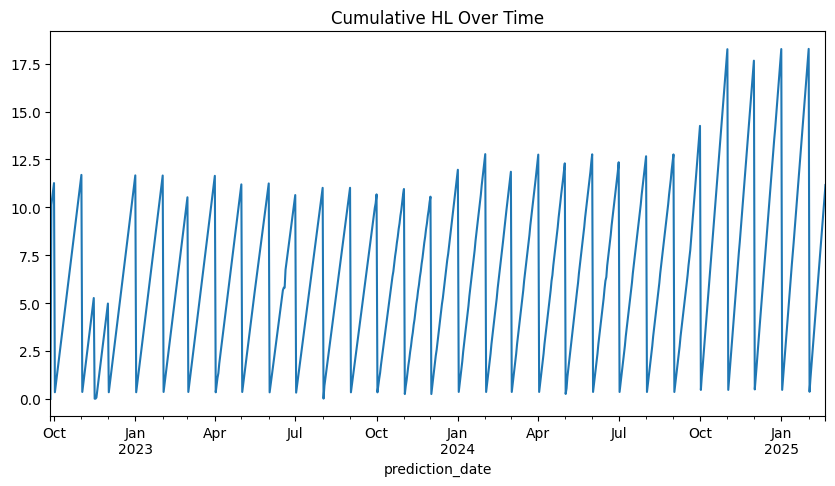

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

# Ensure data is sorted by prediction_date
df = df.sort_values(by="prediction_date")

# Check missing values
print(df.isna().sum())

# Aggregate daily cumulative HL values (if not already cumulative)
#df["cumulative_hl"] = df.groupby("evaluation_date")["hl"].cumsum()

# Create a time series indexed by `prediction_date`
time_series = df.groupby("prediction_date")["hl-retention_lag1"].last()

# Check stationarity
time_series.plot(title="Cumulative HL Over Time", figsize=(10, 5))
plt.show()


In [24]:
time_series.to_csv('time_series.csv')

In [21]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(time_series.dropna())
print(f"ADF Statistic: {adf_test[0]}")
print(f"P-value: {adf_test[1]}")

if adf_test[1] > 0.05:
    print("⚠️ Data is not stationary. Differencing required.")
    time_series = time_series.diff().dropna()
else:
    print("✅ Data is stationary. Proceed with ARIMA.")


ADF Statistic: -9.381611984013528
P-value: 6.932931127274166e-16
✅ Data is stationary. Proceed with ARIMA.


In [23]:
# Automatically find the best ARIMA parameters
auto_model = auto_arima(
    time_series,
    seasonal=False,  # No seasonality in standard ARIMA
    stepwise=True,
    suppress_warnings=True
)

# Print best parameters
print(f"Best ARIMA Order: {auto_model.order}")

# Train ARIMA model
model = ARIMA(time_series, order=auto_model.order)
fitted_model = model.fit()

# Model Summary
print(fitted_model.summary())


/Users/rmeskarian/Projects/ml-pipeline-development/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/rmeskarian/Projects/ml-pipeline-development/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/rmeskarian/Projects/ml-pipeline-development/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/rmeskarian/Projects/ml-pipeline-development/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/rmeskarian/Projects/ml-pipeli

Best ARIMA Order: (0, 1, 0)
                               SARIMAX Results                                
Dep. Variable:      hl-retention_lag1   No. Observations:                  878
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1981.265
Date:                Fri, 14 Mar 2025   AIC                           3964.531
Time:                        16:45:14   BIC                           3969.307
Sample:                    09-27-2022   HQIC                          3966.357
                         - 02-20-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         5.3677      0.064     83.312      0.000       5.241       5.494
Ljung-Box (L1) (Q):                   0.98   Jarque-Bera (JB):             36501.45
Prob(Q):           

/Users/rmeskarian/Projects/ml-pipeline-development/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/rmeskarian/Projects/ml-pipeline-development/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/rmeskarian/Projects/ml-pipeline-development/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/rmeskarian/Projects/ml-pipeline-development/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/rmeskarian/Projects/ml-pipeli

In [31]:
import joblib

# Load the saved ARIMA model
model_path = '/Users/rmeskarian/Projects/ml-pipeline-development/outputs/experiments/arima_regressor/best_arima_model.pkl'
loaded_model = joblib.load(model_path)

print("Loaded ARIMA Model:")
print(loaded_model.summary())


Loaded ARIMA Model:
                               SARIMAX Results                                
Dep. Variable:      hl-retention_lag1   No. Observations:                  100
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -241.742
Date:                Tue, 18 Mar 2025   AIC                            491.485
Time:                        09:50:59   BIC                            501.865
Sample:                    09-27-2022   HQIC                           495.684
                         - 01-04-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1223      0.141      0.867      0.386      -0.154       0.399
ma.L1         -1.6948      0.233     -7.265      0.000      -2.152      -1.238
ma.L2          0.6970      0.188

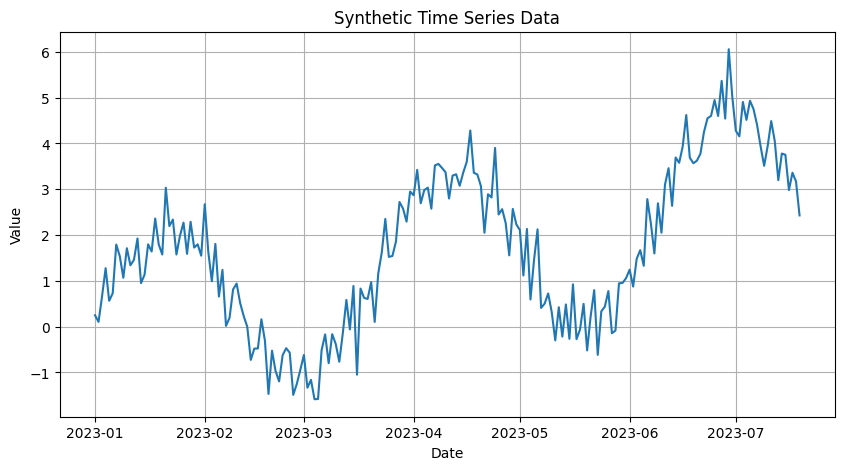


Augmented Dickey-Fuller Test Results:
ADF Statistic: -4.187264787863063
p-value: 0.0006923810216082957

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  200
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -176.008
Date:                Tue, 18 Mar 2025   AIC                            358.015
Time:                        10:14:21   BIC                            367.895
Sample:                    01-01-2023   HQIC                           362.014
                         - 07-19-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1685      0.128     -1.316      0.188      -0.419       0.082
ma.L1

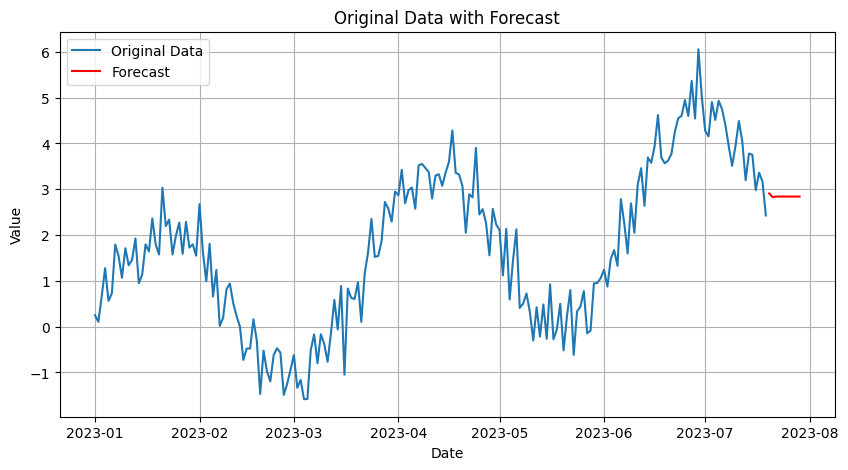

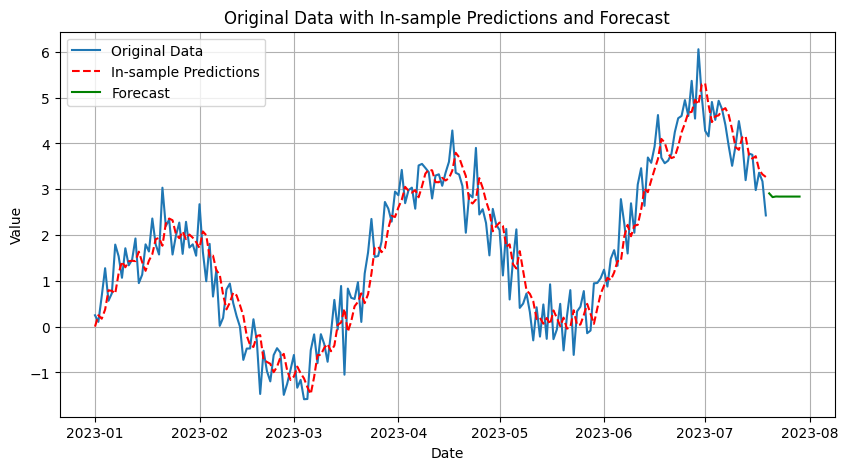

In [36]:
# Generate synthetic time series data for testing
np.random.seed(42)
n_points = 200
t = np.linspace(0, 10, n_points)

# Create a trend component
trend = 0.3 * t

# Create seasonal component 
seasonal = 2 * np.sin(2 * np.pi * t / 4)

# Add some noise
noise = np.random.normal(0, 0.5, n_points)

# Combine components
y = trend + seasonal + noise

# Create a pandas Series with datetime index
dates = pd.date_range(start='2023-01-01', periods=n_points, freq='D')
synthetic_ts = pd.Series(y, index=dates)

# Plot the synthetic data
plt.figure(figsize=(10, 5))
plt.plot(synthetic_ts)
plt.title('Synthetic Time Series Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.show()

# Test stationarity
adf_test = adfuller(synthetic_ts)
print("\nAugmented Dickey-Fuller Test Results:")
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")

# Fit ARIMA model to synthetic data
model = ARIMA(synthetic_ts, order=(1,1,1))
results = model.fit()

# Print model summary
print("\nARIMA Model Summary:")
print(results.summary())

# Make predictions
forecast = results.forecast(steps=10)
print("\nForecast for next 10 periods:")
print(forecast)

# Plot original data and forecast
plt.figure(figsize=(10, 5))
plt.plot(synthetic_ts, label='Original Data')
plt.plot(forecast, label='Forecast', color='red')
plt.title('Original Data with Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()
# Get the full forecast including in-sample predictions
in_sample_predictions = results.get_prediction(start=0)
forecast_mean = in_sample_predictions.predicted_mean

# Plot original data, in-sample predictions, and forecast
plt.figure(figsize=(10, 5))
plt.plot(synthetic_ts, label='Original Data')
plt.plot(forecast_mean, label='In-sample Predictions', color='red', linestyle='--')
plt.plot(forecast, label='Forecast', color='green')
plt.title('Original Data with In-sample Predictions and Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


In [47]:
#synthetic_ts.rename_axis('prediction_date').rename('target')
# Convert the time series into a DataFrame

synthetic_ts_df = synthetic_ts.rename_axis('prediction_date').rename('target').to_frame()
synthetic_ts_df = synthetic_ts_df.reset_index()

synthetic_ts_df.to_parquet('/Users/rmeskarian/Projects/ml-pipeline-development/example/predict_end_month_billable_usage/data/synthetic_ts.parquet')
# Reset index to make prediction_date a regular column and ensure a separate numeric index


In [50]:
synthetic_ts_df.prediction_date.min()

Timestamp('2023-01-01 00:00:00')

In [37]:
synthetic_ts.to_csv('/Users/rmeskarian/Projects/ml-pipeline-development/example/predict_end_month_billable_usage/data/synthetic_ts.csv')


Historical Predictions Shape: (1900, 5)

Historical Predictions Sample:
  prediction_date    target  predicted_target in_sample_start_time  \
0      2023-01-01  0.248357          2.366646           2023-01-01   
1      2023-01-02  0.103648          1.896498           2023-01-01   
2      2023-01-03  0.668423          1.802640           2023-01-01   
3      2023-01-04  1.275934          2.636497           2023-01-01   
4      2023-01-05  0.564261          2.797861           2023-01-01   

  in_sample_end_time  
0         2023-01-10  
1         2023-01-10  
2         2023-01-10  
3         2023-01-10  
4         2023-01-10  

Historical Predictions Statistics:
            target  predicted_target
count  1900.000000       1900.000000
mean      1.184962         11.645454
std       1.426848          6.770109
min      -1.585624          1.802640
25%       0.103357          5.931375
50%       1.238092         10.723807
75%       2.233073         16.580024
max       6.058515         29.341071

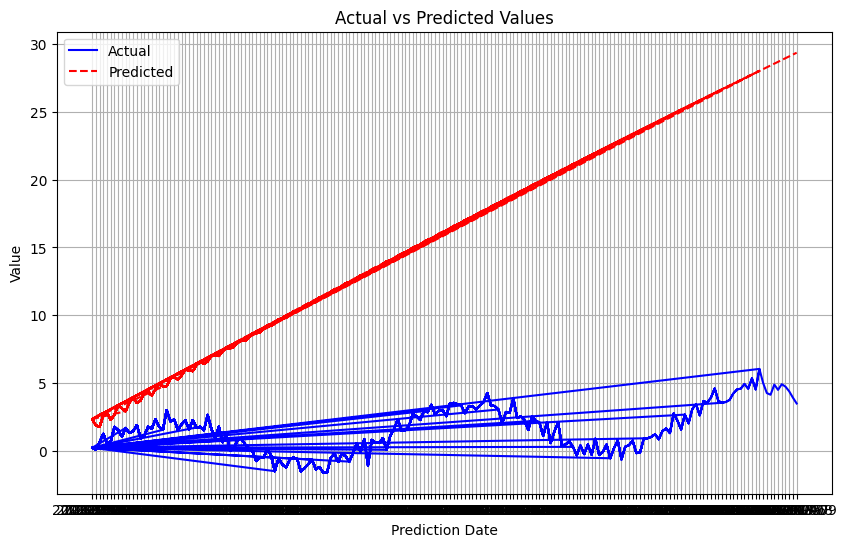

In [57]:
# Load and display historical predictions
import pandas as pd

predictions_path = '/Users/rmeskarian/Projects/ml-pipeline-development/outputs/predict_end_month_billable_usage_None_timeseries_2025_Mar-18/arima_regressor_2025_Mar-18_10-47-24/in_sample_predictions.csv'
historical_predictions = pd.read_csv(predictions_path)

print("\nHistorical Predictions Shape:", historical_predictions.shape)
print("\nHistorical Predictions Sample:")
print(historical_predictions.head())

# Display basic statistics
print("\nHistorical Predictions Statistics:")
print(historical_predictions.describe())

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(historical_predictions['prediction_date'], historical_predictions['target'], label='Actual', color='blue')
plt.plot(historical_predictions['prediction_date'], historical_predictions['predicted_target'], label='Predicted', color='red', linestyle='--')
plt.title('Actual vs Predicted Values')
plt.xlabel('Prediction Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

